<a href="https://colab.research.google.com/github/neverthesameagain/Voilence-Detection/blob/main/Violence_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Voilence Detection Model**
A Deep Learning model that can detect in Violence in Videos and Live Feeds
#### By Aryan Mathur

###Models And Their Accuracy:
####MobileNet Bi LTSM : 97%
####DeVTr : 96%
####YoloV8 : 91%
####Temperal Fusion CNN +LTSM : 91%
####CNN+LTSM : 89%
####ResNet50v2 : 86.6 &
####Inception V3: 78%


WIll be going with MobileNet Bi LTSM with 16FPS analysis


Importing Required Libraries


In [12]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow
import keras
from collections import deque
import matplotlib.pyplot as plt
plt.style.use("seaborn")
from decimal import Decimal


from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from IPython.display import HTML
from base64 import b64encode
import tensorflow as tf
from IPython.display import HTML
from base64 import b64encode
import mimetypes


<ipython-input-12-db9a489e65a6>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


Mount The Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data Visualisation

In [3]:
#Playing Video
def Play_Video(filepath):
    # Read the video file as binary data
    with open(filepath, 'rb') as file:
        video_data = file.read()

    # Determine the MIME type of the video
    mime_type, _ = mimetypes.guess_type(filepath)

    # Encode the video data as base64
    video_base64 = b64encode(video_data).decode()

    # Construct the HTML code for embedding the video
    html = '<video controls autoplay loop>'
    html += '<source src="data:%s;base64,%s" type="%s">' % (mime_type, video_base64, mime_type)
    html += '</video>'

    # Display the HTML code in the notebook
    return HTML(html)

In [6]:
# Classes Directories

NonViolnceVideos_Dir = "/content/drive/MyDrive/archive/real life violence situations/Real Life Violence Dataset/NonViolence/"
ViolnceVideos_Dir = "/content/drive/MyDrive/archive/real life violence situations/Real Life Violence Dataset/Violence/"

# Retrieve the list of all the video files present in the Class Directory.
NonViolence_files_names_list = os.listdir(NonViolnceVideos_Dir)
Violence_files_names_list = os.listdir(ViolnceVideos_Dir)

# Check if directories exist
if not os.path.isdir(NonViolnceVideos_Dir):
  print(f"Error: Directory '{NonViolnceVideos_Dir}' does not exist.")
  exit()

if not os.path.isdir(ViolnceVideos_Dir):
  print(f"Error: Directory '{ViolnceVideos_Dir}' does not exist.")
  exit()

# Retrieve video file lists
try:
  NonViolence_files_names_list = os.listdir(NonViolnceVideos_Dir)
  Violence_files_names_list = os.listdir(ViolnceVideos_Dir)
except FileNotFoundError:
  print("Error: Video files not found in the directories.")
  exit()


In [15]:
import random

def select_random_video(video_list):
    if not video_list:
        print("Error: Empty list.")
        return None
    else:
        return random.choice(video_list)

# Randomly select videos (assuming non-empty lists)
Random_NonViolence_Video = select_random_video(NonViolence_files_names_list)
Random_Violence_Video = select_random_video(Violence_files_names_list)

Playing Random Non Voilence Video

In [16]:
Play_Video(f"{NonViolnceVideos_Dir}/{Random_NonViolence_Video}")

Playing a random Voilence Video

In [17]:
Play_Video(f"{ViolnceVideos_Dir}/{Random_Violence_Video}")

#Frame Extraction


In [18]:

# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 16


In [ ]:
def frames_extraction(video_path):

    frames_list = []

    # Read the Video File
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)


    video_reader.release()

    return frames_list



#DataSet Preparation

In [ ]:
def create_dataset():

    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes.
    for class_index, class_name in enumerate(CLASSES_LIST):

        print(f'Extracting Data of Class: {class_name}')
        class_files = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        percentage_done = Decimal(len(features) / (len(CLASSES_LIST) * len(class_files))) * 100
        print(f'Progress: {percentage_done:.2f}% done')

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [ ]:
# Create the dataset.
#features, labels, video_files_paths = create_dataset()
#Dataset already created and pasted on drive , so no need of this

In [ ]:
# Saving the extracted data
#np.save("features.npy",features)
#np.save("labels.npy",labels)
#np.save("video_files_paths.npy",video_files_paths)

#Dataset already created and pasted on drive , so no need of this



In [20]:


# Define the path to the mounted drive directory
mounted_drive_path = "/content/drive/MyDrive"

# Load data from the mounted drive
features = np.load(f"{mounted_drive_path}/features.npy")
labels = np.load(f"{mounted_drive_path}/labels.npy")
video_files_paths = np.load(f"{mounted_drive_path}/video_files_paths.npy")


Encoding and splitting DataSet


In [21]:
# convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [22]:
# Split the Data into Train ( 90% ) and Test Set ( 10% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1,
                                                                            shuffle = True, random_state = 42)

In [23]:
print(features_train.shape,labels_train.shape )
print(features_test.shape, labels_test.shape)

(1799, 16, 64, 64, 3) (1799, 2)
(200, 16, 64, 64, 3) (200, 2)


##Importing MobileNet and Finetuning it

In [24]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2( include_top=False , weights="imagenet")

#Fine-Tuning to make the last 40 layer trainable
mobilenet.trainable=True

for layer in mobilenet.layers[:-40]:
  layer.trainable=False

mobilenet.summary()

9406464/9406464 [==============================] - 2s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

##Building The Model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, TimeDistributed, Flatten, LSTM, Bidirectional, Dropout, Dense

def create_model():
    model = Sequential()

    # Input layer to match features shape
    model.add(Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    # TimeDistributed layer to apply MobileNet to each frame
    model.add(TimeDistributed(mobilenet))
    model.add(Dropout(0.25))

    # Flatten the output from TimeDistributed layer
    model.add(TimeDistributed(Flatten()))

    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=32, backward_layer=LSTM(units=32, go_backwards=True))))
    model.add(Dropout(0.25))

    # Dense layers with dropout
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))

    # Output layer
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()

    return model


# **Model Construction**

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDi  (None, 16, 2, 2, 1280)    2257984   
 stributed)                                                      
                                                                 
 dropout_6 (Dropout)         (None, 16, 2, 2, 1280)    0         
                                                                 
 time_distributed_3 (TimeDi  (None, 16, 5120)          0         
 stributed)                                                      
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                1319168   
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                      

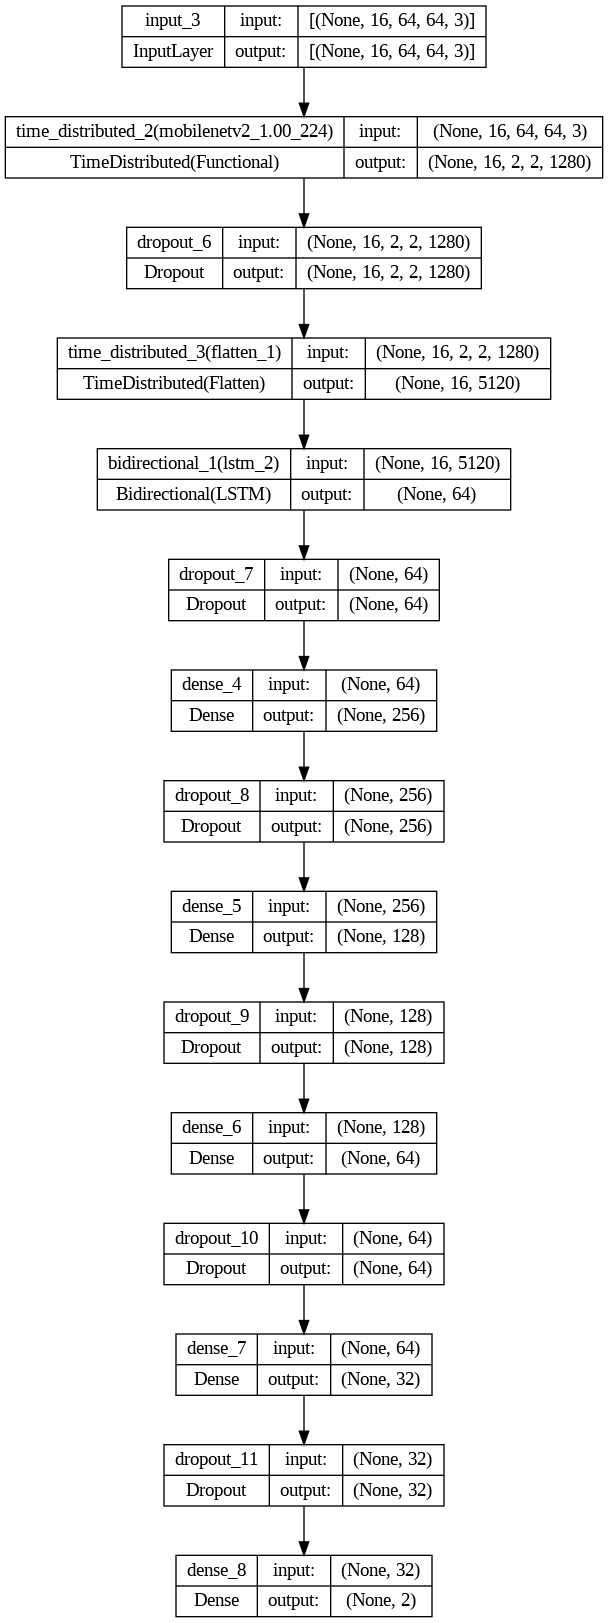

In [27]:
# Constructing the Model
CLASSES_LIST = ["NonViolence","Violence"]
MoBiLSTM_model = create_model()

# Plot the structure of the contructed LRCN model.
plot_model(MoBiLSTM_model, to_file = 'MobBiLSTM_model_structure_plot.png', show_shapes = True, show_layer_names = True)

CallBack Specification and Fitting

In [28]:
import tensorflow as tf

# Define Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Define Reduce Learning Rate on Plateau Callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5, min_lr=0.00005, verbose=1)

# Compile the model
MoBiLSTM_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Fit the model
history = MoBiLSTM_model.fit(x=features_train, y=labels_train, epochs=50, batch_size=8,
                             shuffle=True, validation_split=0.2, callbacks=[early_stopping, reduce_lr])


Epoch 1/50
180/180 [==============================] - 32s 88ms/step - loss: 0.6943 - accuracy: 0.5073 - val_loss: 0.6878 - val_accuracy: 0.6028 - lr: 0.0100
Epoch 2/50
180/180 [==============================] - 12s 65ms/step - loss: 0.6912 - accuracy: 0.5094 - val_loss: 0.6799 - val_accuracy: 0.6278 - lr: 0.0100
Epoch 3/50
180/180 [==============================] - 11s 62ms/step - loss: 0.6691 - accuracy: 0.6108 - val_loss: 0.6351 - val_accuracy: 0.6889 - lr: 0.0100
Epoch 4/50
180/180 [==============================] - 11s 63ms/step - loss: 0.5776 - accuracy: 0.7234 - val_loss: 0.5115 - val_accuracy: 0.8028 - lr: 0.0100
Epoch 5/50
180/180 [==============================] - 12s 65ms/step - loss: 0.4706 - accuracy: 0.8124 - val_loss: 0.7218 - val_accuracy: 0.7528 - lr: 0.0100
Epoch 6/50
180/180 [==============================] - 11s 63ms/step - loss: 0.4138 - accuracy: 0.8610 - val_loss: 0.7173 - val_accuracy: 0.7667 - lr: 0.0100
Epoch 7/50
180/180 [==============================] - 12s 

In [32]:
model_evaluation_history = MoBiLSTM_model.evaluate(features_test, labels_test)


7/7 [==============================] - 1s 67ms/step - loss: 0.4630 - accuracy: 0.8950


Model Evaluation

In [78]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    """
    Plot two metrics from model training history.

    Args:
    - model_training_history (History): History object returned by model.fit()
    - metric_name_1 (str): Name of the first metric to plot
    - metric_name_2 (str): Name of the second metric to plot
    - plot_name (str): Title of the plot

    Returns:
    - None
    """

    # Extract metric values from training history
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Get the number of epochs
    epochs = range(1, len(metric_value_1) + 1)

    # Plot the metrics
    plt.plot(epochs, metric_value_1, 'b', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label=metric_name_2)

    # Set plot title and legend
    plt.title(plot_name)
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()

    # Show plot
    plt.show()


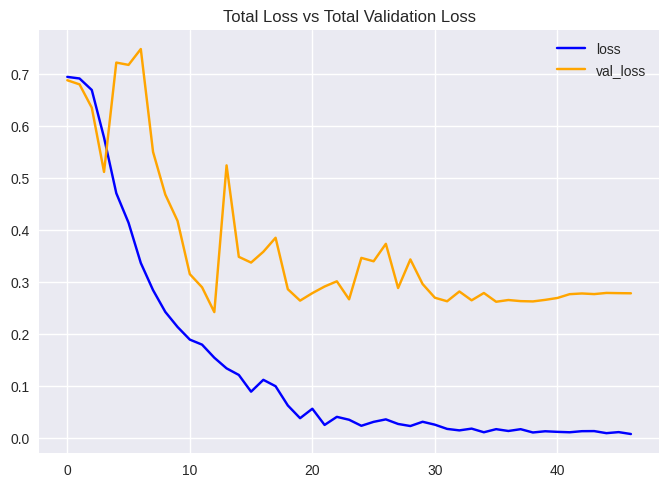

In [34]:
plot_metric(MobBiLSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

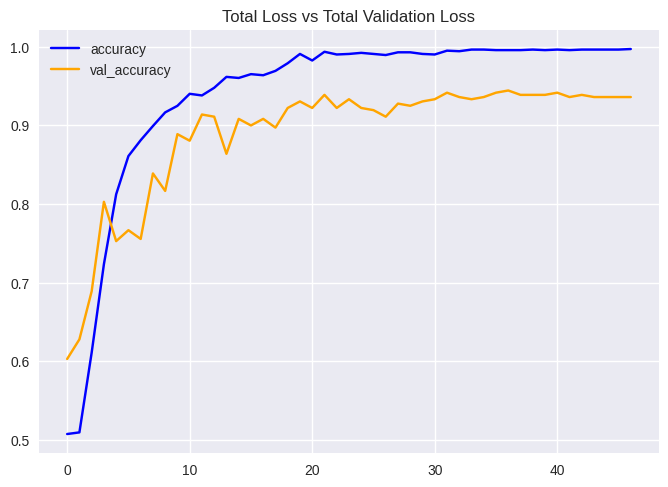

In [35]:
plot_metric(MobBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')



##Predicting The Test Set

In [36]:
labels_predict = MoBiLSTM_model.predict(features_test)


7/7 [==============================] - 3s 60ms/step


In [37]:
# Decoding the data to use in Metrics
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [38]:
labels_test_normal.shape , labels_predict.shape

((200,), (200,))

Accuracy Score


In [39]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy score.
accuracy = accuracy_score(labels_test_normal, labels_predict)

# Print the accuracy score.
print('Accuracy Score:', accuracy)


Accuracy Score is :  0.895


Confusion Matrix

[Text(0, 0.5, 'NonViolence'), Text(0, 1.5, 'Violence')]

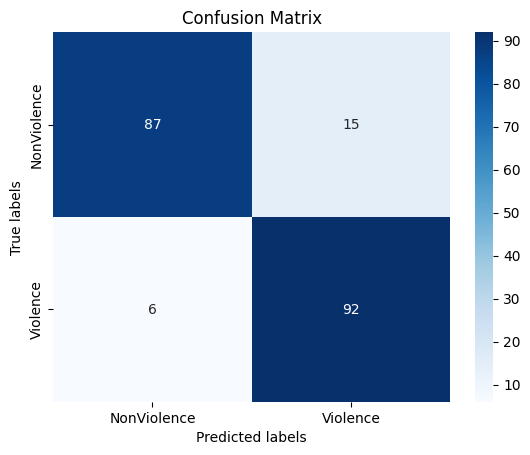

In [77]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create a subplot.
ax = plt.subplot()

# Generate the confusion matrix.
conf_matrix = confusion_matrix(labels_test_normal, labels_predict)

# Plot the confusion matrix as a heatmap with annotations.
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', ax=ax)

# Set labels and title for the plot.
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Set tick labels for x and y axes.
ax.xaxis.set_ticklabels(['NonViolence', 'Violence'])
ax.yaxis.set_ticklabels(['NonViolence', 'Violence'])



Classification Report

In [75]:
from sklearn.metrics import classification_report
# Generate classification report for model evaluation.

ClassificationReport = classification_report(labels_test_normal,labels_predict)
# Print the classification report.

print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.94      0.85      0.89       102
           1       0.86      0.94      0.90        98

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.89       200
weighted avg       0.90      0.90      0.89       200



# Prediction and Classification

In [74]:
from collections import deque

def predict_frames(video_file_path, output_file_path, SEQUENCE_LENGTH):
    # Open the video file for reading.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # VideoWriter to save the output video.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc(*'mp4v'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_width, original_height))

    # Queue to store video frames.
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)

    # Previous predicted label.
    prev_label = ''

    # Iterate over frames in the video.
    while video_reader.isOpened():
        # Read a frame from the video.
        ok, frame = video_reader.read()
        if not ok:
            break

        # Resize the frame.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame.
        normalized_frame = resized_frame / 255

        # Add the normalized frame to the queue.
        frames_queue.append(normalized_frame)

        # Check if enough frames are in the queue for prediction.
        if len(frames_queue) == SEQUENCE_LENGTH:
            # Predict labels for the sequence of frames.
            predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_queue, axis=0))[0]

            # Get the index of the predicted label.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name corresponding to the predicted label.
            predicted_class_name = CLASSES_LIST[predicted_label]

            # Add label to the frame.
            color = (0, 0, 255) if predicted_class_name == "Violence" else (0, 255, 0)
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.3, color, 6)

        # Write the frame to the output video.
        video_writer.write(frame)

    # Release video reader and writer.
    video_reader.release()
    video_writer.release()


In [73]:
def show_pred_frames(pred_video_path, SEQUENCE_LENGTH):
    plt.figure(figsize=(20, 15))

    # Open the predicted video file
    video_reader = cv2.VideoCapture(pred_video_path)

    # Get the number of frames in the video.
    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Maximum number of frames to select
    max_frames_to_select = min(frames_count - SEQUENCE_LENGTH, 12)

    # Select random frames if available
    if max_frames_to_select > 0:
        random_frames = random.sample(range(SEQUENCE_LENGTH, frames_count), max_frames_to_select)
        random_frames.sort()

        for counter, random_index in enumerate(random_frames, 1):
            plt.subplot(5, 4, counter)

            # Set the current frame position of the video.
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)

            success, frame = video_reader.read()

            if not success:
                break

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            plt.imshow(frame)
            plt.tight_layout()

    else:
        print(f"The output video has less than {SEQUENCE_LENGTH + 11} frames. Showing all available frames.")
        for i in range(SEQUENCE_LENGTH, frames_count):
            # Read and display each frame
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, i)
            success, frame = video_reader.read()
            if not success:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            plt.subplot(int(np.ceil(frames_count - SEQUENCE_LENGTH / 4)), 4, i - SEQUENCE_LENGTH + 1)  # Adjust layout for variable number of frames
            plt.imshow(frame)
            plt.tight_layout()

    video_reader.release()
    plt.show()

In [67]:
import cv2
import numpy as np

def predict_video(video_file_path, SEQUENCE_LENGTH):

    # Open the video file
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames.
    frames_list = []

    # Store the predicted class in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the skip interval for frames.
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Iterate over frames to create a sequence.
    for frame_counter in range(0, video_frames_count, skip_frames_window):

        # Set the current frame position.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter)

        success, frame = video_reader.read()

        if not success:
            break

        # Resize and normalize the frame.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0

        # Append the pre-processed frame to the list.
        frames_list.append(normalized_frame)

    # Convert the list of frames to a numpy array.
    frames_array = np.array(frames_list)

    # Predict labels probabilities for the sequence.
    predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_array, axis=0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]

    # Display the predicted class along with the prediction confidence.
    print(f'Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    # Release the video reader.
    video_reader.release()


Randomise Video


In [62]:
# Randomly select videos (assuming non-empty lists)
Random_NonViolence_Video = select_random_video(NonViolence_files_names_list)
Random_Violence_Video = select_random_video(Violence_files_names_list)

In [44]:
# Construct the output video path.
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

output_video_file_path = f'{test_videos_directory}/Output-Test-Video.mp4'

Predict a Violent Video

1/1 [==============================] - 0s 25ms/step


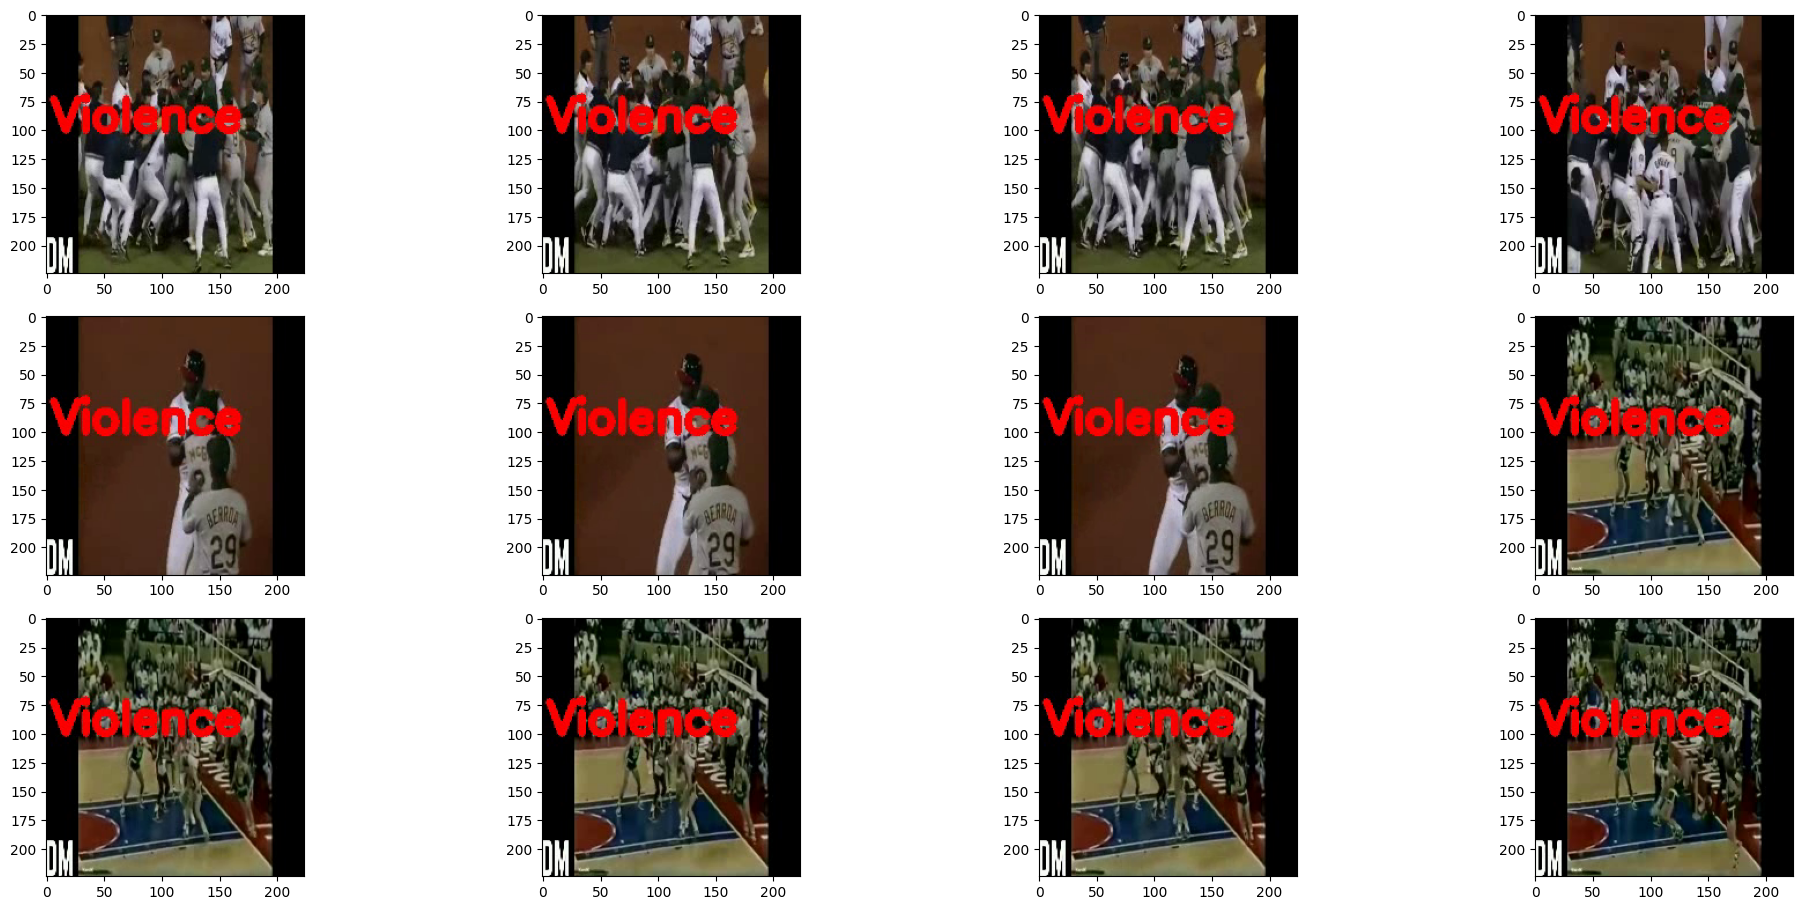

In [69]:


# Specifying video to be predicted
input_video_file_path = f"{ViolnceVideos_Dir}/{Random_Violence_Video}"

# Perform Prediction on the Test Video.
predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Show random frames from the output video
show_pred_frames(output_video_file_path)



In [70]:
# Play the actual video

predict_video(input_video_file_path, SEQUENCE_LENGTH)
Play_Video(output_video_file_path)

1/1 [==============================] - 1s 826ms/step
Predicted: Violence
Confidence: 0.9998375177383423


Predict a Non Violent Video

1/1 [==============================] - 0s 24ms/step


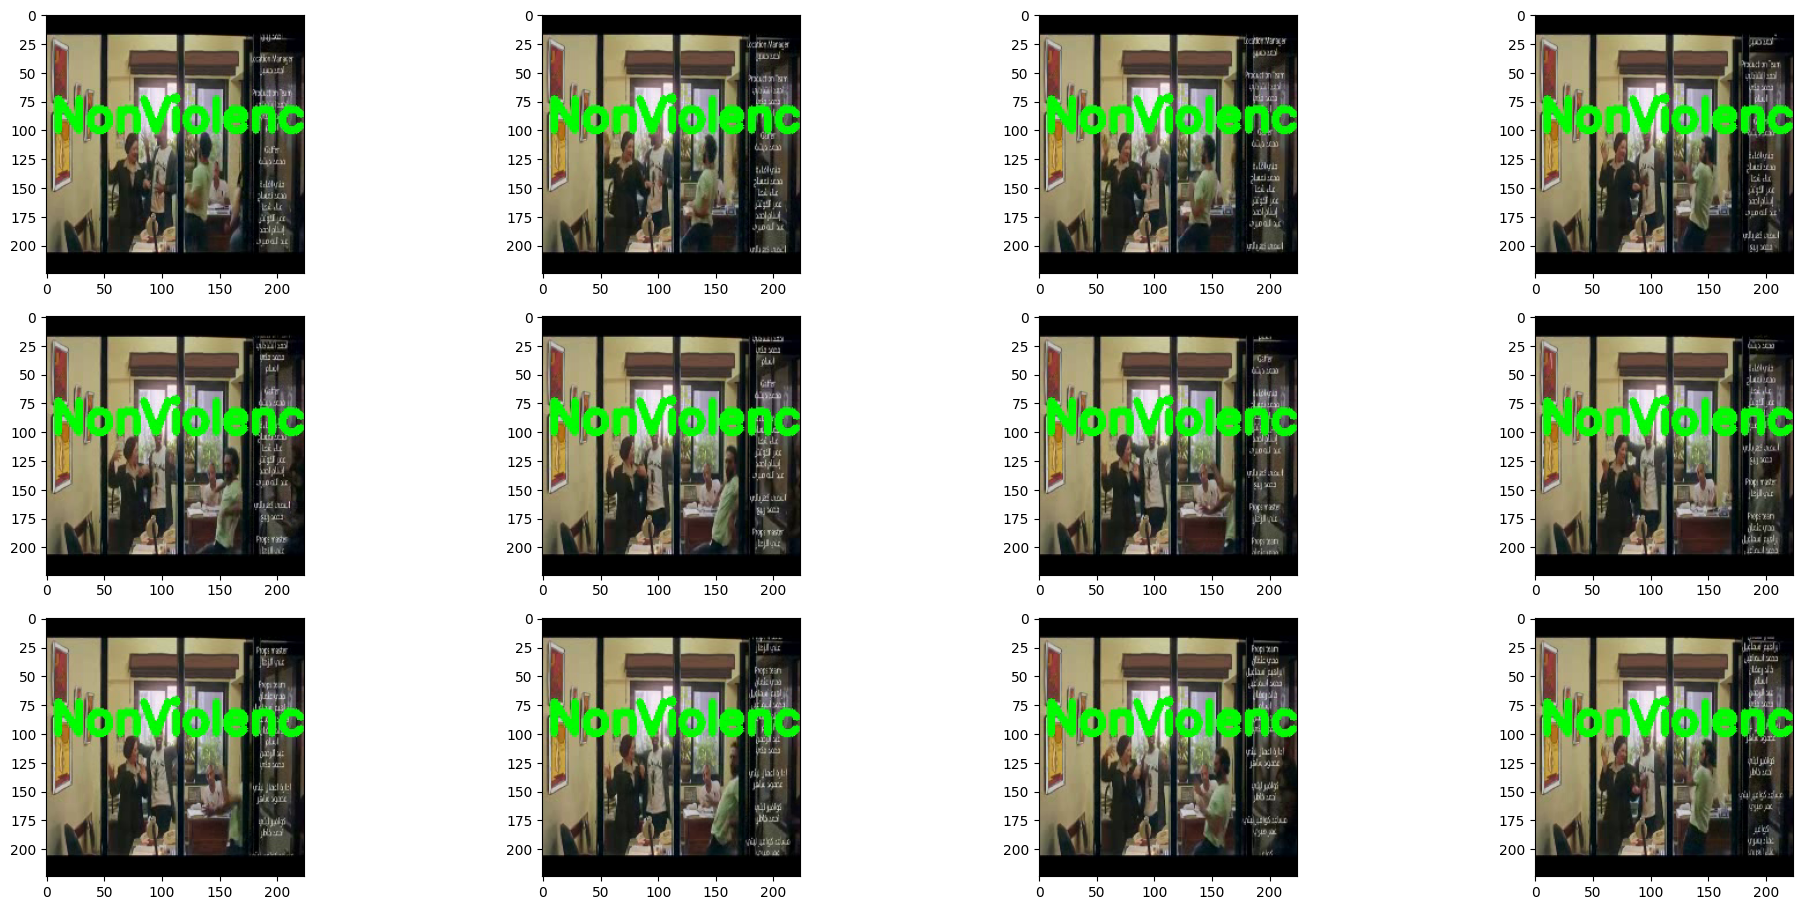

In [71]:
# Specifying video to be predicted
input_video_file_path = f"{NonViolnceVideos_Dir}/{Random_NonViolence_Video}"

# Perform Prediction on the Test Video.
predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Show random frames from the output video
show_pred_frames(output_video_file_path)

In [72]:

predict_video(input_video_file_path, SEQUENCE_LENGTH)

# Play the actual video
Play_Video(output_video_file_path)

1/1 [==============================] - 0s 45ms/step
Predicted: NonViolence
Confidence: 0.9999995231628418
